# Project Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
figsize = (16,8)

# Dataset Exploration

## Load Dataset

In [4]:
df_vt = pd.read_csv('./data/VT-clean.csv.gz', compression='gzip', low_memory=False)

In [54]:
df_vt.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,is_white
0,VT-2010-00001,VT,2010-07-01,00:10,East Montpelier,Washington County,50023.0,COUNTY RD,MIDDLESEX VSP,M,...,Moving Violation,Moving violation,False,No Search Conducted,N/A,False,Citation,False,-1.562157e+09,True
3,VT-2010-00004,VT,2010-07-01,00:11,Whiting,Addison County,50001.0,N MAIN ST,NEW HAVEN VSP,F,...,Moving Violation,Moving violation,False,No Search Conducted,N/A,False,Arrest for Violation,True,-3.126844e+08,True
4,VT-2010-00005,VT,2010-07-01,00:35,Hardwick,Caledonia County,50005.0,i91 nb mm 62,ROYALTON VSP,M,...,Moving Violation,Moving violation,False,No Search Conducted,N/A,False,Written Warning,False,9.225661e+08,True
5,VT-2010-00006,VT,2010-07-01,00:44,Hardwick,Caledonia County,50005.0,64000 I 91 N; MM64 I 91 N,ROYALTON VSP,F,...,Vehicle Equipment,Equipment,False,No Search Conducted,N/A,False,Written Warning,False,-6.032327e+08,True
8,VT-2010-00009,VT,2010-07-01,01:10,Rochester,Windsor County,50027.0,36000 I 91 S; MM36 I 91 S,ROCKINGHAM VSP,M,...,Moving Violation,Moving violation,False,No Search Conducted,N/A,False,Written Warning,False,2.939526e+08,False


In [6]:
df_vt.columns

Index(['id', 'state', 'stop_date', 'stop_time', 'location_raw', 'county_name',
       'county_fips', 'fine_grained_location', 'police_department',
       'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw',
       'driver_race', 'violation_raw', 'violation', 'search_conducted',
       'search_type_raw', 'search_type', 'contraband_found', 'stop_outcome',
       'is_arrested', 'officer_id'],
      dtype='object')

## Clean Dataset

In [7]:
df_vt.count()

id                       283285
state                    283285
stop_date                283285
stop_time                283285
location_raw             282591
county_name              282580
county_fips              282580
fine_grained_location    282938
police_department        283285
driver_gender            281573
driver_age_raw           282114
driver_age               281999
driver_race_raw          279301
driver_race              278468
violation_raw            281107
violation                281107
search_conducted         283285
search_type_raw          281045
search_type                3419
contraband_found         283251
stop_outcome             280960
is_arrested              283285
officer_id               283273
dtype: int64

In [8]:
# Fill missing search type values with placeholder
df_vt['search_type'].fillna('N/A', inplace=True)

# Drop rows with missing values
df_vt.dropna(inplace=True)

In [9]:
df_vt.count()

id                       273181
state                    273181
stop_date                273181
stop_time                273181
location_raw             273181
county_name              273181
county_fips              273181
fine_grained_location    273181
police_department        273181
driver_gender            273181
driver_age_raw           273181
driver_age               273181
driver_race_raw          273181
driver_race              273181
violation_raw            273181
violation                273181
search_conducted         273181
search_type_raw          273181
search_type              273181
contraband_found         273181
stop_outcome             273181
is_arrested              273181
officer_id               273181
dtype: int64

## Explore Data

In [10]:
df_vt['county_name'].value_counts()

Windham County       37715
Windsor County       36464
Chittenden County    24815
Orange County        24679
Washington County    24633
Rutland County       22885
Addison County       22813
Bennington County    22250
Franklin County      19715
Caledonia County     16505
Orleans County       10344
Lamoille County       8604
Essex County          1239
Grand Isle County      520
Name: county_name, dtype: int64

In [12]:
df_vt['violation_raw'].value_counts()

Moving Violation              212100
Vehicle Equipment              50600
Externally Generated Stop       6160
Investigatory Stop              3608
Suspicion of DWI                 711
(Winooski) Be On Look Rqst         1
(Winooski) Mtr Vhc Vltn            1
Name: violation_raw, dtype: int64

In [11]:
df_vt['violation'].value_counts()

Moving violation      212100
Equipment              50600
Other                   9768
DUI                      711
Other (non-mapped)         2
Name: violation, dtype: int64

In [13]:
df_vt['stop_outcome'].value_counts()

Written Warning         166488
Citation                103401
Arrest for Violation      3206
Warrant Arrest              76
Verbal Warning              10
Name: stop_outcome, dtype: int64

In [15]:
df_vt['driver_gender'].value_counts()

M    174070
F     99111
Name: driver_gender, dtype: int64

In [16]:
df_vt['driver_race'].value_counts()

White       261339
Black         5571
Asian         3446
Hispanic      2562
Other          263
Name: driver_race, dtype: int64

In [17]:
df_vt = df_vt[df_vt['driver_race'] != 'Other']

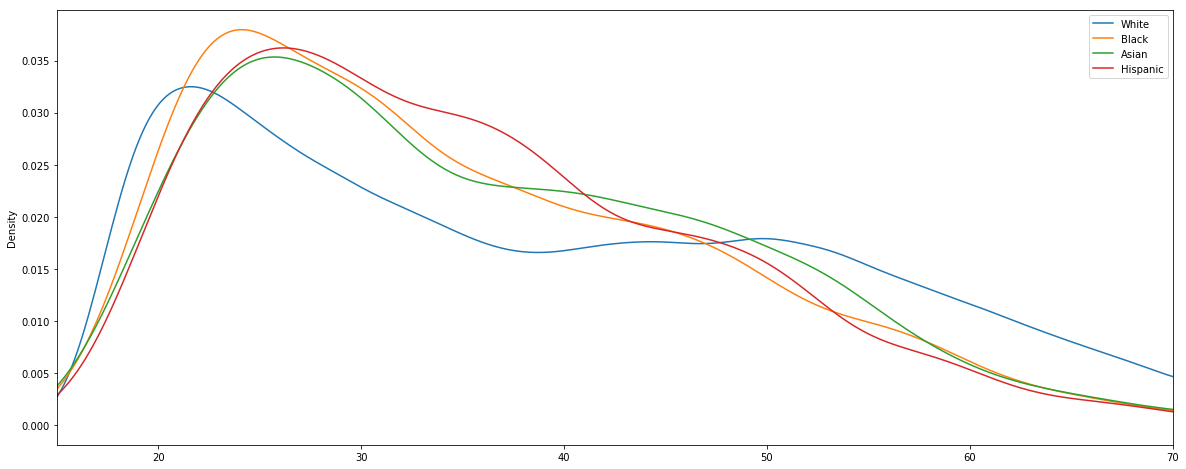

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(15, 70)
for race in df_vt['driver_race'].unique():
    s = df_vt[df_vt['driver_race'] == race]['driver_age']
    s.plot.kde(ax=ax, label=race)
ax.legend()

fig.savefig('images/race_age_dist.png', bbox_inches='tight')

# Analyze Violation and Outcome Data

In [58]:
def compute_outcome_stats(df):
    """Compute statistics regarding the relative quanties of arrests, warnings, and citations"""
    n_total = len(df)
    n_warnings = len(df[df['stop_outcome'] == 'Written Warning'])
    n_citations = len(df[df['stop_outcome'] == 'Citation'])
    n_arrests = len(df[df['stop_outcome'] == 'Arrest for Violation'])
    citations_per_warning = n_citations / n_warnings
    arrest_rate = n_arrests / n_total
    
    return(pd.Series(data = { 
        'n_total': n_total,
        'n_warnings': n_warnings,
        'n_citations': n_citations,
        'n_arrests': n_arrests,
        'citations_per_warning': citations_per_warning,
        'arrest_rate': arrest_rate
    }))

In [59]:
compute_outcome_stats(df_vt)

arrest_rate                   0.011721
citations_per_warning         0.620751
n_arrests                  3199.000000
n_citations              103270.000000
n_total                  272918.000000
n_warnings               166363.000000
dtype: float64

In [61]:
df_vt.groupby('driver_gender').apply(compute_outcome_stats)

,arrest_rate,citations_per_warning,n_arrests,n_citations,n_total,n_warnings
driver_gender,,,,,,
F,0.007038,0.548033,697.0,34805.0,99036.0,63509.0
M,0.014389,0.665652,2502.0,68465.0,173882.0,102854.0


In [63]:
df_vt.groupby('driver_race').apply(compute_outcome_stats)

,arrest_rate,citations_per_warning,n_arrests,n_citations,n_total,n_warnings
driver_race,,,,,,
Asian,0.006384,1.002339,22.0,1714.0,3446.0,1710.0
Black,0.019925,0.802379,111.0,2428.0,5571.0,3026.0
Hispanic,0.016393,0.865827,42.0,1168.0,2562.0,1349.0
White,0.011571,0.611188,3024.0,97960.0,261339.0,160278.0


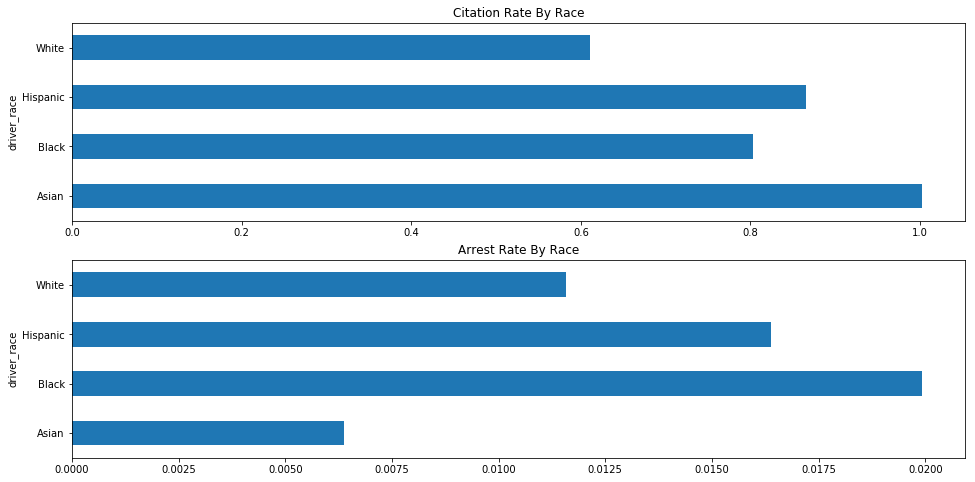

In [26]:
race_agg = df_vt.groupby(['driver_race']).apply(compute_outcome_stats)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)
race_agg['citations_per_warning'].plot.barh(ax=axes[0], figsize=figsize, title="Citation Rate By Race")
race_agg['arrest_rate'].plot.barh(ax=axes[1], figsize=figsize, title='Arrest Rate By Race')

fig.savefig('images/citations_and_arrests_by_race.png', bbox_inches='tight')

In [68]:
df_vt.groupby(['driver_race','violation']).apply(compute_outcome_stats)

arrest_rate  citations_per_warning  n_arrests  \
driver_race violation                                                           
Asian       DUI                    0.200000               0.333333        2.0   
            Equipment              0.006270               0.132143        2.0   
            Moving violation       0.005563               1.183190       17.0   
            Other                  0.016393               0.875000        1.0   
Black       DUI                    0.200000               0.142857        2.0   
            Equipment              0.029181               0.220651       26.0   
            Moving violation       0.016052               0.942385       71.0   
            Other                  0.048583               2.205479       12.0   
Hispanic    DUI                    0.200000               3.000000        2.0   
            Equipment              0.023560               0.187898        9.0   
            Moving violation       0.012422               1.058824       26.0   
            Other                  0.064935               1.366667        5.0   
White       DUI                    0.192364               0.455026      131.0   
            Equipment              0.012233               0.190486      599.0   
            Moving violation       0.008635               0.732720     1747.0   
            Other                  0.058378               1.476672      547.0   
            Other (non-mapped)     0.000000               1.000000        0.0   

                                n_citations   n_total  n_warnings  
driver_race violation                                              
Asian       DUI                         2.0      10.0         6.0  
            Equipment                  37.0     319.0       280.0  
            Moving violation         1647.0    3056.0      1392.0  
            Other                      28.0      61.0        32.0  
Black       DUI                         1.0      10.0         7.0  
            Equipment                 156.0     891.0       707.0  
            Moving violation         2110.0    4423.0      2239.0  
            Other                     161.0     247.0        73.0  
Hispanic    DUI                         6.0      10.0         2.0  
            Equipment                  59.0     382.0       314.0  
            Moving violation         1062.0    2093.0      1003.0  
            Other                      41.0      77.0        30.0  
White       DUI                       172.0     681.0       378.0  
            Equipment                7736.0   48965.0     40612.0  
            Moving violation        84797.0  202321.0    115729.0  
            Other                    5254.0    9370.0      3558.0  
            Other (non-mapped)          1.0       2.0         1.0

In [23]:
# Create new column to represent whether the driver is White
df_vt['is_white'] = df_vt['driver_race'] == 'White'

# Remove violation with too few data points
df_vt_filtered = df_vt[~df_vt['violation'].isin(['Other (non-mapped)', 'DUI'])]

In [67]:
df_vt_filtered.groupby(['is_white','violation']).apply(compute_outcome_stats)

arrest_rate  citations_per_warning  n_arrests  \
is_white violation                                                         
False    Equipment            0.023241               0.193697       37.0   
         Moving violation     0.011910               1.039922      114.0   
         Other                0.046753               1.703704       18.0   
True     Equipment            0.012233               0.190486      599.0   
         Moving violation     0.008635               0.732720     1747.0   
         Other                0.058378               1.476672      547.0   

                           n_citations   n_total  n_warnings  
is_white violation                                            
False    Equipment               252.0    1592.0      1301.0  
         Moving violation       4819.0    9572.0      4634.0  
         Other                   230.0     385.0       135.0  
True     Equipment              7736.0   48965.0     40612.0  
         Moving violation      84797.0  202321.0    115729.0  
         Other                  5254.0    9370.0      3558.0

In [27]:
df_vt_filtered = df_vt[~df_vt['violation'].isin(['Other (non-mapped)', 'DUI'])]

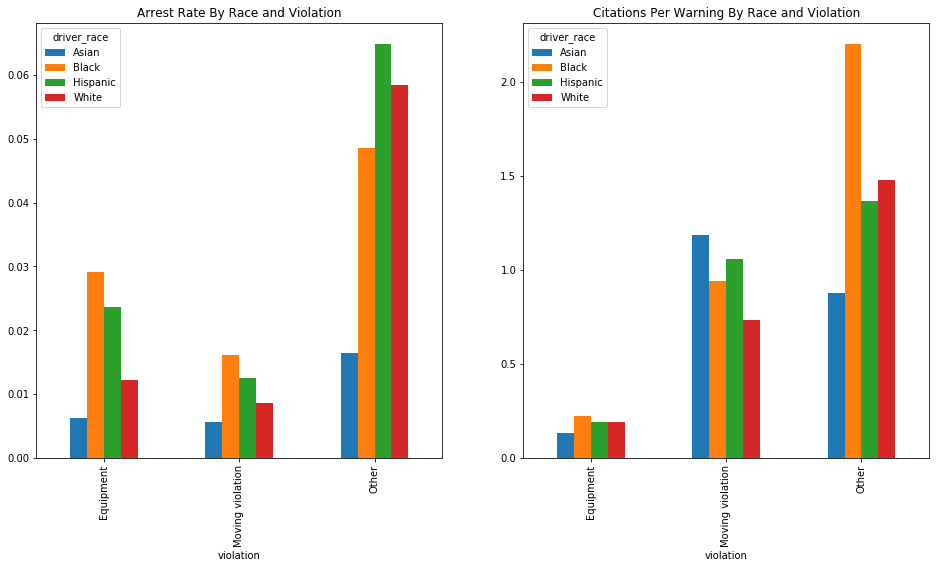

In [29]:
race_stats = df_vt_filtered.groupby(['violation', 'driver_race']).apply(compute_outcome_stats).unstack()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
race_stats.plot.bar(y='arrest_rate', ax=axes[0], title='Arrest Rate By Race and Violation')
race_stats.plot.bar(cy='citations_per_warning', ax=axes[1], title='Citations Per Warning By Race and Violation')
                                                       
fig.savefig('images/citations_and_arrests_by_race_and_violation.png', bbox_inches='tight')


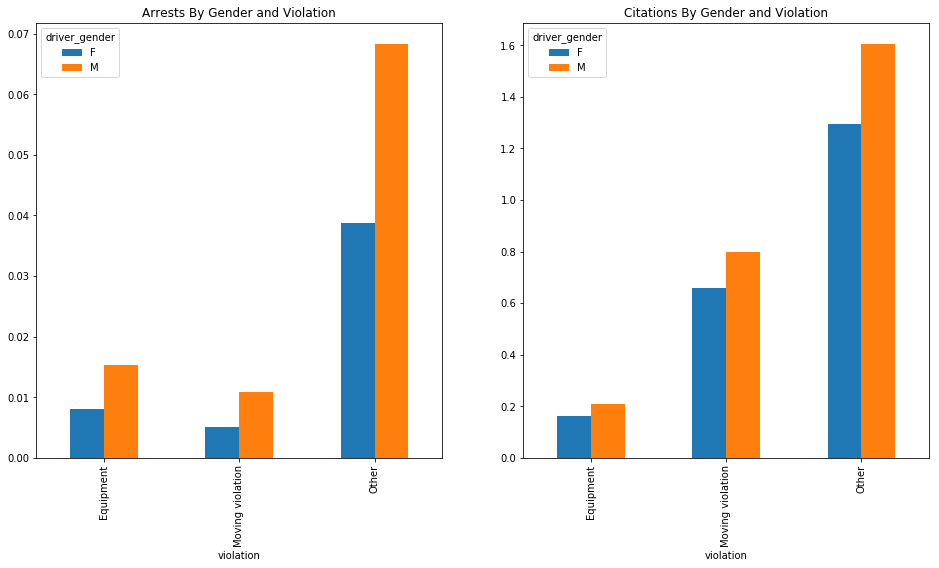

In [28]:
gender_stats = df_vt_filtered.groupby(['violation','driver_gender']).apply(compute_outcome_stats).unstack()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
ax_gender_arrests = gender_stats.plot.bar(y='arrest_rate', ax=axes[0], title='Arrests By Gender and Violation', figsize=figsize)
ax_gender_citations = gender_stats.plot.bar(y='citations_per_warning', ax=axes[1], title='Citations By Gender and Violation', figsize=figsize)

fig.savefig('images/citations_and_arrests_by_gender_and_violation.png', bbox_inches='tight')


# Analyze Search Data

In [30]:
def compute_search_stats(df):
    """Compute the search rate and hit rate"""
    search_conducted = df['search_conducted']
    contraband_found = df['contraband_found']
    n_stops     = len(search_conducted)
    n_searches  = sum(search_conducted)
    n_hits      = sum(contraband_found)
    
    if (n_stops) < 50:
        search_rate = None
    else:
        search_rate = n_searches / n_stops
    
    if (n_searches) < 5:
        hit_rate = None
    else:
        hit_rate = n_hits / n_searches
    
    return(pd.Series(data = { 
        'n_stops': n_stops,
        'n_searches': n_searches,
        'n_hits': n_hits,
        'search_rate': search_rate,
        'hit_rate': hit_rate
    }))

In [31]:
compute_search_stats(df_vt)

hit_rate            0.796865
n_hits           2593.000000
n_searches       3254.000000
n_stops        272918.000000
search_rate         0.011923
dtype: float64

In [70]:
df_vt.groupby('driver_gender').apply(compute_search_stats)

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_gender,,,,,
F,0.789392,506.0,641.0,99036.0,0.006472
M,0.798699,2087.0,2613.0,173882.0,0.015027


In [72]:
age_groups = pd.cut(df_vt["driver_age"], np.arange(15, 70, 5))
df_vt.groupby(age_groups).apply(compute_search_stats)

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_age,,,,,
"(15, 20]",0.847988,569.0,671.0,27418.0,0.024473
"(20, 25]",0.838000,838.0,1000.0,43275.0,0.023108
"(25, 30]",0.788462,492.0,624.0,34759.0,0.017952
"(30, 35]",0.766756,286.0,373.0,27746.0,0.013443
"(35, 40]",0.742991,159.0,214.0,23203.0,0.009223
"(40, 45]",0.692913,88.0,127.0,24055.0,0.005280
"(45, 50]",0.575472,61.0,106.0,24103.0,0.004398
"(50, 55]",0.706667,53.0,75.0,22517.0,0.003331
"(55, 60]",0.833333,30.0,36.0,17502.0,0.002057


In [74]:
df_vt.groupby('driver_race').apply(compute_search_stats)

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.785714,22.0,28.0,3446.0,0.008125
Black,0.686620,195.0,284.0,5571.0,0.050978
Hispanic,0.644231,67.0,104.0,2562.0,0.040593
White,0.813601,2309.0,2838.0,261339.0,0.010859


In [38]:
def generate_county_search_stats_scatter(df, state):
    """Generate a scatter plot of search rate vs. hit rate by race and county"""
    race_location_agg = df.groupby(['county_name','driver_race']).apply(compute_search_stats)

    fig, ax = plt.subplots(figsize=figsize)
    for c, frame in race_location_agg.groupby('driver_race'):
        ax.scatter(x=frame['hit_rate'], y=frame['search_rate'], s=150, label=c)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True)
    ax.set_xlabel('Hit Rate')
    ax.set_ylabel('Search Rate')
    ax.set_title("Search Stats By County and Race - {}".format(state))
    return fig

In [39]:
def generate_comparison_scatter(df, ax, state, race, field):
    """Generate scatter plot comparing field for white drivers with minority drivers"""
    race_location_agg = df.groupby(['county_name','driver_race']).apply(compute_search_stats).reset_index().dropna()    
    race_location_agg = race_location_agg.pivot(index='county_name', columns='driver_race', values=field)
    ax = race_location_agg.plot.scatter(ax=ax, x='White', y=race, s=150)
    ax.set_xlabel('{} - White'.format(field, ))
    ax.set_ylabel('{} - {}'.format(field, race))
    ax.set_title("{} By County - {}".format(field, state))
    lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    return ax
    

In [40]:
def generate_comparison_scatters(df, state):
    """Generate scatter plots comparing search rates of white drivers with black and hispanic drivers"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    generate_comparison_scatter(df, axes[0][0], state, 'Black', 'search_rate')
    generate_comparison_scatter(df, axes[0][1], state, 'Hispanic', 'search_rate')
    generate_comparison_scatter(df, axes[1][0], state, 'Black', 'hit_rate')
    generate_comparison_scatter(df, axes[1][1], state, 'Hispanic', 'hit_rate')
    return fig

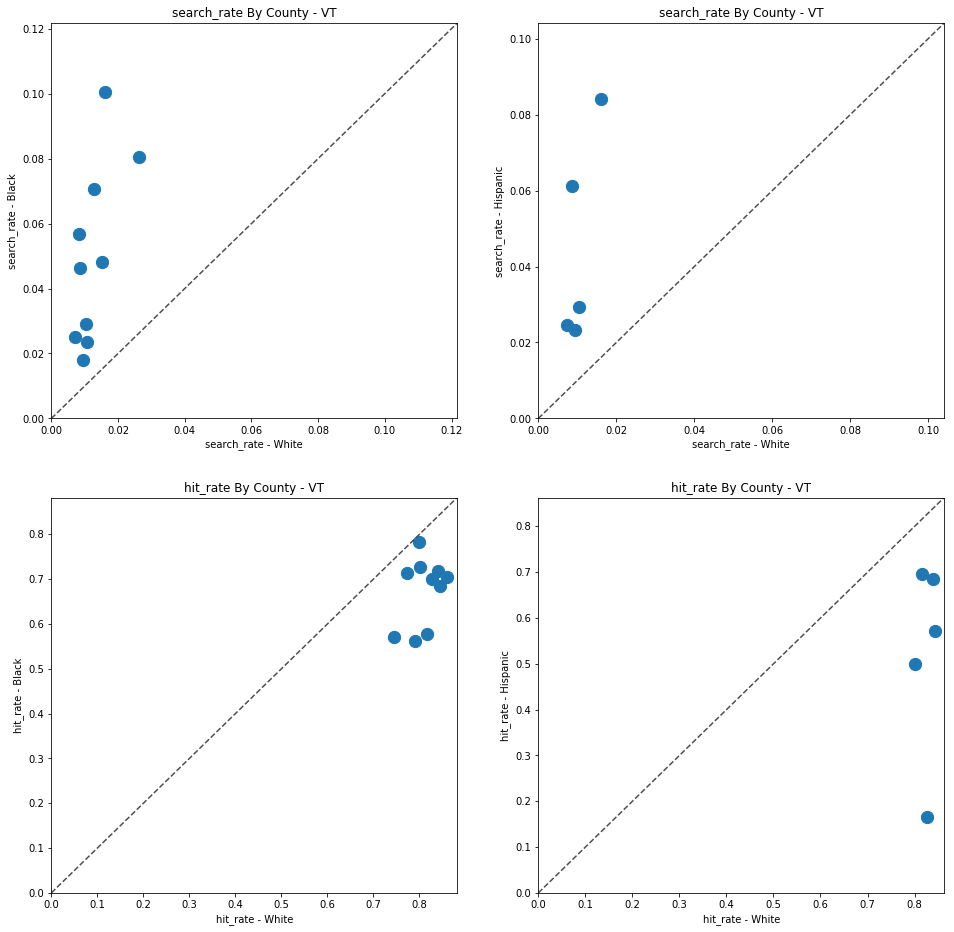

In [41]:
fig = generate_comparison_scatters(df_vt, 'VT')
fig.savefig('images/search_scatters_vt.png', bbox_inches='tight')


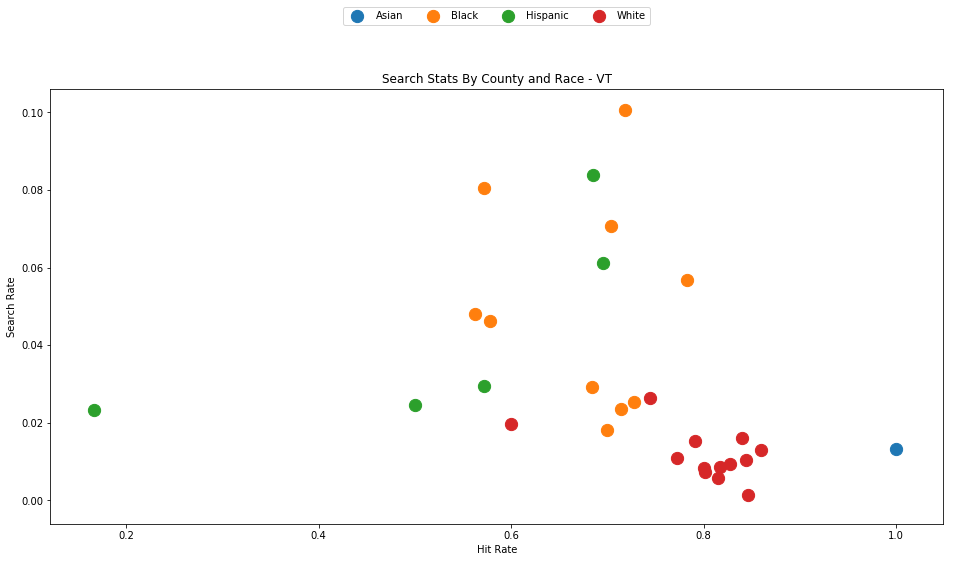

In [42]:
fig = generate_county_search_stats_scatter(df_vt, "VT")
fig.savefig('images/county_scatter_vt.png', bbox_inches='tight')


# Massachusetts

In [43]:
fields = ['county_name', 'driver_race', 'search_conducted', 'contraband_found']

In [48]:
df_ma = pd.read_csv('./data/MA-clean.csv.gz', compression='gzip', low_memory=False, usecols=fields)
df_ma.dropna(inplace=True)
df_ma = df_ma[df_ma['driver_race'] != 'Other']

In [78]:
df_ma.groupby('driver_race').apply(compute_search_stats)

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.331169,357.0,1078.0,101942.0,0.010575
Black,0.487150,4170.0,8560.0,350498.0,0.024422
Hispanic,0.449502,5007.0,11139.0,337782.0,0.032977
White,0.523037,18220.0,34835.0,2527393.0,0.013783


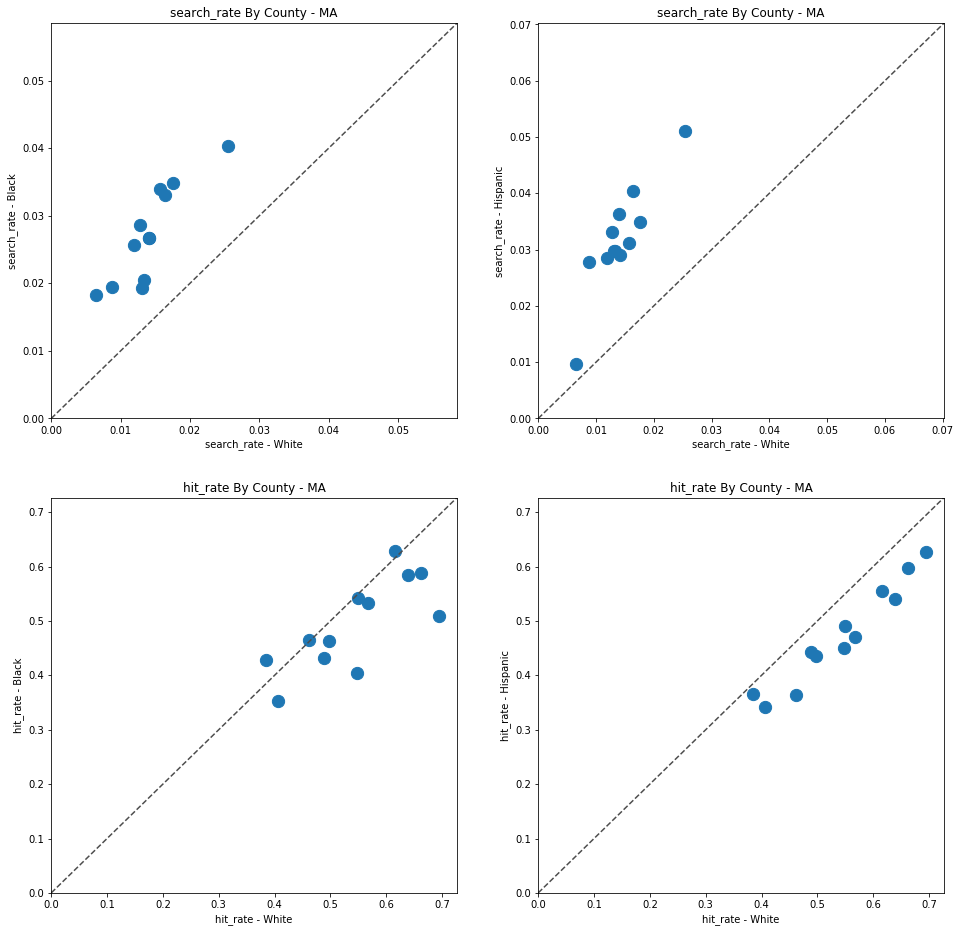

In [51]:
fig = generate_comparison_scatters(df_ma, 'MA')
fig.savefig('images/search_scatters_ma.png', bbox_inches='tight')


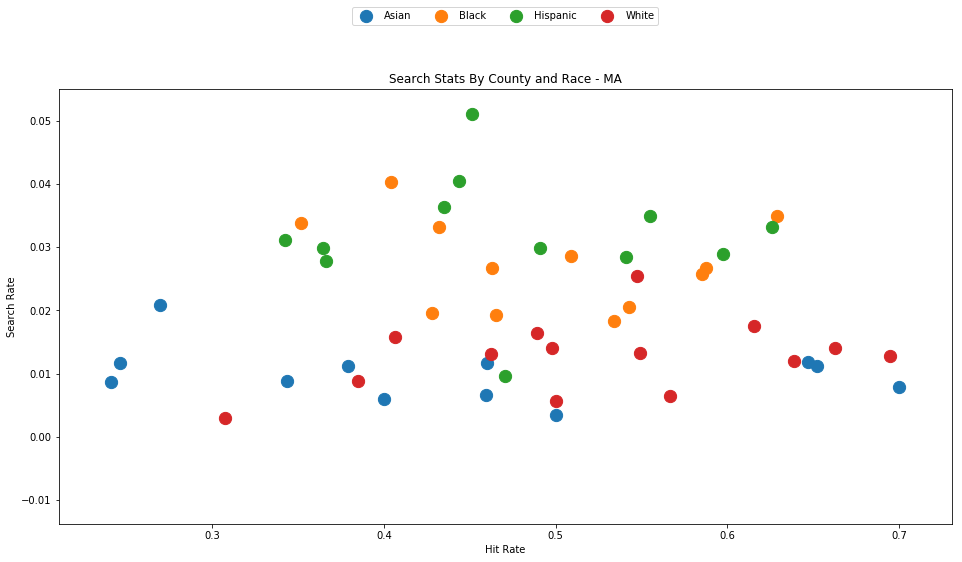

In [50]:
fig = generate_county_search_stats_scatter(df_ma, "MA")
fig.savefig('images/county_scatter_ma.png', bbox_inches='tight')


# Wisconsin

In [80]:
df_wi = pd.read_csv('./data/WI-clean.csv.gz', compression='gzip', low_memory=False, usecols=fields)
df_wi.dropna(inplace=True)
df_wi = df_wi[df_wi['driver_race'] != 'Other']

In [81]:
df_wi.groupby('driver_race').apply(compute_search_stats)

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>hit_rate</th>      <th>n_hits</th>      <th>n_searches</th>      <th>n_stops</th>      <th>search_rate</th>    </tr>    <tr>      <th>driver_race</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Asian</th>      <td>0.470817</td>      <td>121.0</td>      <td>257.0</td>      <td>24577.0</td>      <td>0.010457</td>    </tr>    <tr>      <th>Black</th>      <td>0.477574</td>      <td>1299.0</td>      <td>2720.0</td>      <td>56050.0</td>      <td>0.048528</td>    </tr>    <tr>      <th>Hispanic</th>      <td>0.415741</td>      <td>449.0</td>      <td>1080.0</td>      <td>35210.0</td>      <td>0.030673</td>    </tr>    <tr>      <th>White</th>      <td>0.526300</td>      <td>5103.0</td>      <td>9696.0</td>      <td>778227.0</td>      <td>0.012459</td>    </tr>  </tbody></table>'

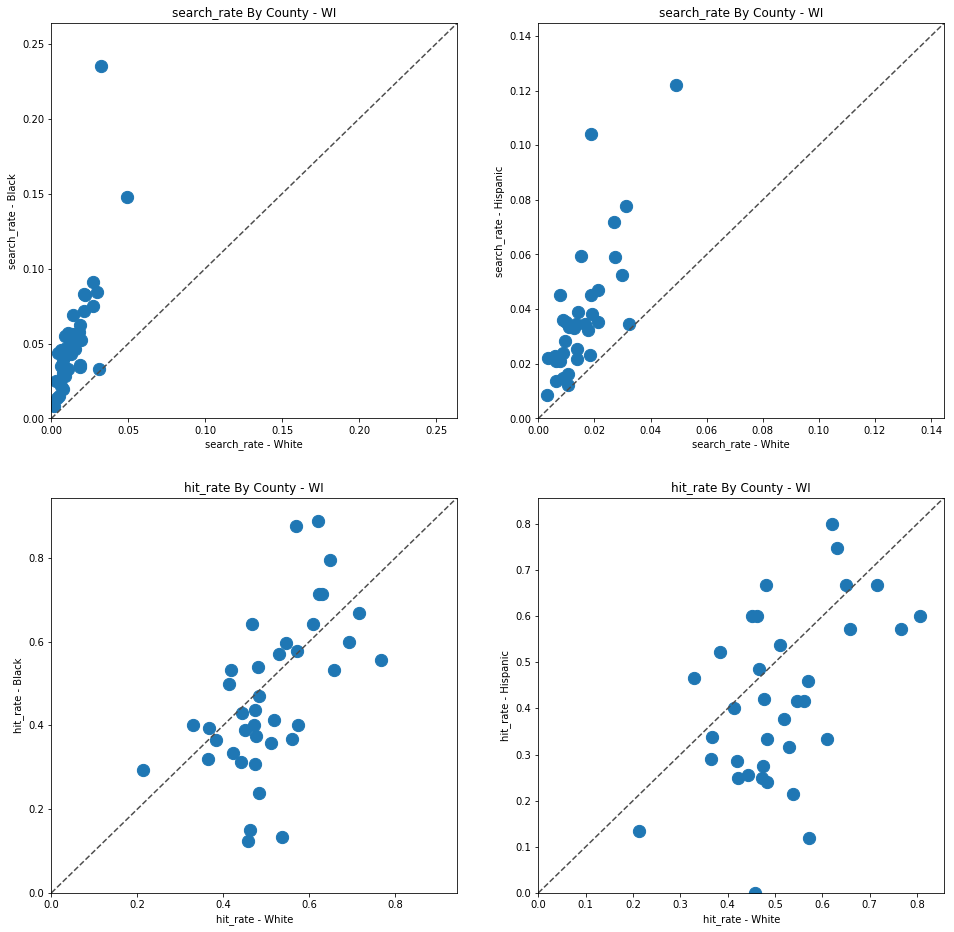

In [46]:
fig = generate_comparison_scatters(df_wi, 'WI')
fig.savefig('images/search_scatters_wi.png', bbox_inches='tight')


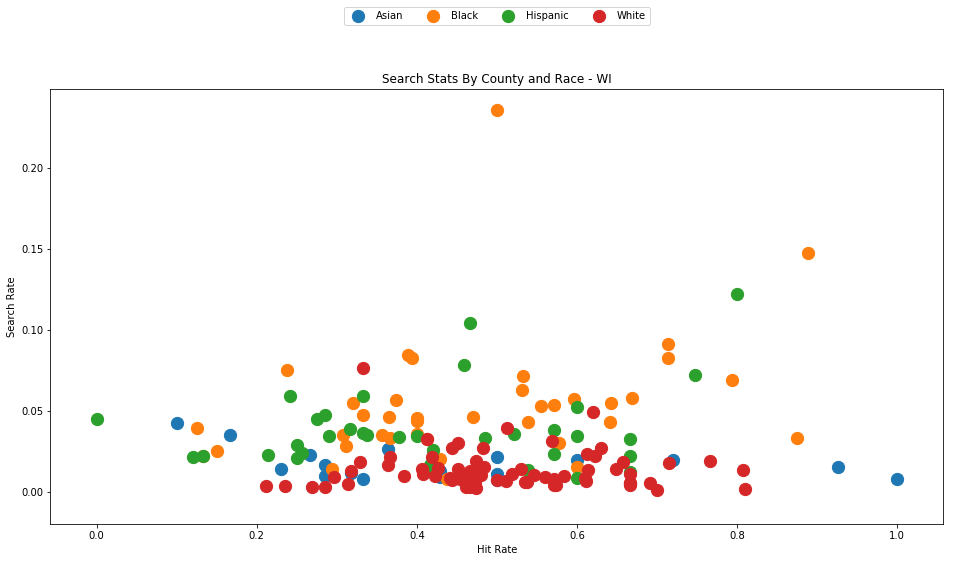

In [47]:
fig = generate_county_search_stats_scatter(df_wi, "WI")
fig.savefig('images/county_scatter_wi.png', bbox_inches='tight')
